# System Level Quantization - REAL Implementation

This notebook compares FP16, 8-bit, and 4-bit quantization using actual model loading and inference.

In [1]:
import torch
import time
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import gc

# --- CONFIGURATION ---
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "gpt2"  # Using smaller model for faster testing
generation_length = 512

print(f"Using device: {device}")
print(f"Model: {model_name}")
print(f"Generation length: {generation_length}")

# --- VRAM Monitoring Helper Function ---
def get_vram_usage():
    """Returns the current GPU memory usage in GB."""
    if device == "cuda":
        torch.cuda.synchronize()
        return torch.cuda.memory_allocated(0) / (1024**3)
    return 0

def cleanup_memory():
    """Clean up GPU memory."""
    gc.collect()
    if device == "cuda":
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

def run_inference_test(model, tokenizer, test_name):
    """Run inference test and measure performance."""
    print(f"\n--- Running test: {test_name} ---")
    
    input_ids = torch.tensor([[tokenizer.bos_token_id]], dtype=torch.long).to(device)
    past_key_values = None
    timings = []
    vram_usage = []
    
    with torch.no_grad():
        for i in range(generation_length):
            start_time = time.perf_counter()
            outputs = model(input_ids=input_ids[:, -1:], past_key_values=past_key_values, use_cache=True)
            next_token_id = torch.argmax(outputs.logits[:, -1, :], dim=-1).unsqueeze(-1)
            input_ids = torch.cat([input_ids, next_token_id], dim=-1)
            past_key_values = outputs.past_key_values
            end_time = time.perf_counter()
            
            timings.append((end_time - start_time) * 1000)
            vram_usage.append(get_vram_usage())
            
            if (i + 1) % 100 == 0:
                print(f"Generated {i + 1}/{generation_length} tokens...")
    
    avg_time = sum(timings) / len(timings)
    avg_vram = sum(vram_usage) / len(vram_usage)
    max_vram = max(vram_usage)
    
    print(f"{test_name} complete:")
    print(f"  Average time/token: {avg_time:.2f} ms")
    print(f"  Average VRAM: {avg_vram:.3f} GB")
    print(f"  Max VRAM: {max_vram:.3f} GB")
    
    return timings, vram_usage, avg_time, avg_vram, max_vram

# Load tokenizer (shared across all models)
tokenizer = AutoTokenizer.from_pretrained(model_name)
print("Tokenizer loaded.")
print("="*60)

/home/sriney/miniconda3/envs/hawai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
Model: gpt2
Generation length: 512
Tokenizer loaded.
Tokenizer loaded.


In [2]:
# Test 1: FP16 Model (Baseline)
print("\n" + "="*60)
print("TEST 1: FP16 (Baseline)")
print("="*60)

model_fp16 = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16
).to(device)
model_fp16.config.use_cache = True

fp16_timings, fp16_vram, fp16_avg_time, fp16_avg_vram, fp16_max_vram = run_inference_test(
    model_fp16, tokenizer, "FP16 Baseline"
)

# Clean up
del model_fp16
cleanup_memory()
print("\nFP16 model cleaned up from memory.")


TEST 1: FP16 (Baseline)


`torch_dtype` is deprecated! Use `dtype` instead!



--- Running test: FP16 Baseline ---
Generated 100/512 tokens...
Generated 100/512 tokens...
Generated 200/512 tokens...
Generated 200/512 tokens...
Generated 300/512 tokens...
Generated 300/512 tokens...
Generated 400/512 tokens...
Generated 400/512 tokens...
Generated 500/512 tokens...
Generated 500/512 tokens...
FP16 Baseline complete:
  Average time/token: 21.75 ms
  Average VRAM: 0.266 GB
  Max VRAM: 0.275 GB

FP16 model cleaned up from memory.
FP16 Baseline complete:
  Average time/token: 21.75 ms
  Average VRAM: 0.266 GB
  Max VRAM: 0.275 GB

FP16 model cleaned up from memory.


In [3]:
# Test 2: 8-bit Quantization
print("\n" + "="*60)
print("TEST 2: 8-bit Quantization")
print("="*60)

model_8bit = AutoModelForCausalLM.from_pretrained(
    model_name,
    load_in_8bit=True,
    device_map="auto"
)
model_8bit.config.use_cache = True

int8_timings, int8_vram, int8_avg_time, int8_avg_vram, int8_max_vram = run_inference_test(
    model_8bit, tokenizer, "8-bit Quantization"
)

# Clean up
del model_8bit
cleanup_memory()
print("\n8-bit model cleaned up from memory.")


TEST 2: 8-bit Quantization


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.



--- Running test: 8-bit Quantization ---
Generated 100/512 tokens...
Generated 100/512 tokens...
Generated 200/512 tokens...
Generated 200/512 tokens...
Generated 300/512 tokens...
Generated 300/512 tokens...
Generated 400/512 tokens...
Generated 400/512 tokens...
Generated 500/512 tokens...
Generated 500/512 tokens...
8-bit Quantization complete:
  Average time/token: 61.95 ms
  Average VRAM: 0.182 GB
  Max VRAM: 0.191 GB

8-bit model cleaned up from memory.
8-bit Quantization complete:
  Average time/token: 61.95 ms
  Average VRAM: 0.182 GB
  Max VRAM: 0.191 GB

8-bit model cleaned up from memory.


In [4]:
# Test 3: 4-bit Quantization
print("\n" + "="*60)
print("TEST 3: 4-bit Quantization")
print("="*60)

model_4bit = AutoModelForCausalLM.from_pretrained(
    model_name,
    load_in_4bit=True,
    device_map="auto"
)
model_4bit.config.use_cache = True

int4_timings, int4_vram, int4_avg_time, int4_avg_vram, int4_max_vram = run_inference_test(
    model_4bit, tokenizer, "4-bit Quantization"
)

# Clean up
del model_4bit
cleanup_memory()
print("\n4-bit model cleaned up from memory.")


TEST 3: 4-bit Quantization


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.



--- Running test: 4-bit Quantization ---
Generated 100/512 tokens...
Generated 100/512 tokens...
Generated 200/512 tokens...
Generated 200/512 tokens...
Generated 300/512 tokens...
Generated 300/512 tokens...
Generated 400/512 tokens...
Generated 400/512 tokens...
Generated 500/512 tokens...
Generated 500/512 tokens...
4-bit Quantization complete:
  Average time/token: 31.62 ms
  Average VRAM: 0.147 GB
  Max VRAM: 0.156 GB
4-bit Quantization complete:
  Average time/token: 31.62 ms
  Average VRAM: 0.147 GB
  Max VRAM: 0.156 GB

4-bit model cleaned up from memory.

4-bit model cleaned up from memory.


In [5]:
# --- Results Summary ---
print("\n" + "="*60)
print("RESULTS SUMMARY")
print("="*60)

results = {
    'FP16 Baseline': {
        'avg_time': fp16_avg_time,
        'avg_vram': fp16_avg_vram,
        'max_vram': fp16_max_vram
    },
    '8-bit Quantization': {
        'avg_time': int8_avg_time,
        'avg_vram': int8_avg_vram,
        'max_vram': int8_max_vram
    },
    '4-bit Quantization': {
        'avg_time': int4_avg_time,
        'avg_vram': int4_avg_vram,
        'max_vram': int4_max_vram
    }
}

for name, metrics in results.items():
    print(f"\n{name}:")
    print(f"  Avg Time/Token: {metrics['avg_time']:.2f} ms")
    print(f"  Avg VRAM: {metrics['avg_vram']:.3f} GB")
    print(f"  Max VRAM: {metrics['max_vram']:.3f} GB")

# Calculate savings
print("\n" + "="*60)
print("MEMORY SAVINGS vs FP16 Baseline:")
print("="*60)
int8_savings = (1 - int8_avg_vram / fp16_avg_vram) * 100
int4_savings = (1 - int4_avg_vram / fp16_avg_vram) * 100

print(f"8-bit: {int8_savings:.1f}% VRAM reduction")
print(f"4-bit: {int4_savings:.1f}% VRAM reduction")


RESULTS SUMMARY

FP16 Baseline:
  Avg Time/Token: 21.75 ms
  Avg VRAM: 0.266 GB
  Max VRAM: 0.275 GB

8-bit Quantization:
  Avg Time/Token: 61.95 ms
  Avg VRAM: 0.182 GB
  Max VRAM: 0.191 GB

4-bit Quantization:
  Avg Time/Token: 31.62 ms
  Avg VRAM: 0.147 GB
  Max VRAM: 0.156 GB

MEMORY SAVINGS vs FP16 Baseline:
8-bit: 31.7% VRAM reduction
4-bit: 44.7% VRAM reduction



📊 Graph saved as 'quantization_comparison.png'


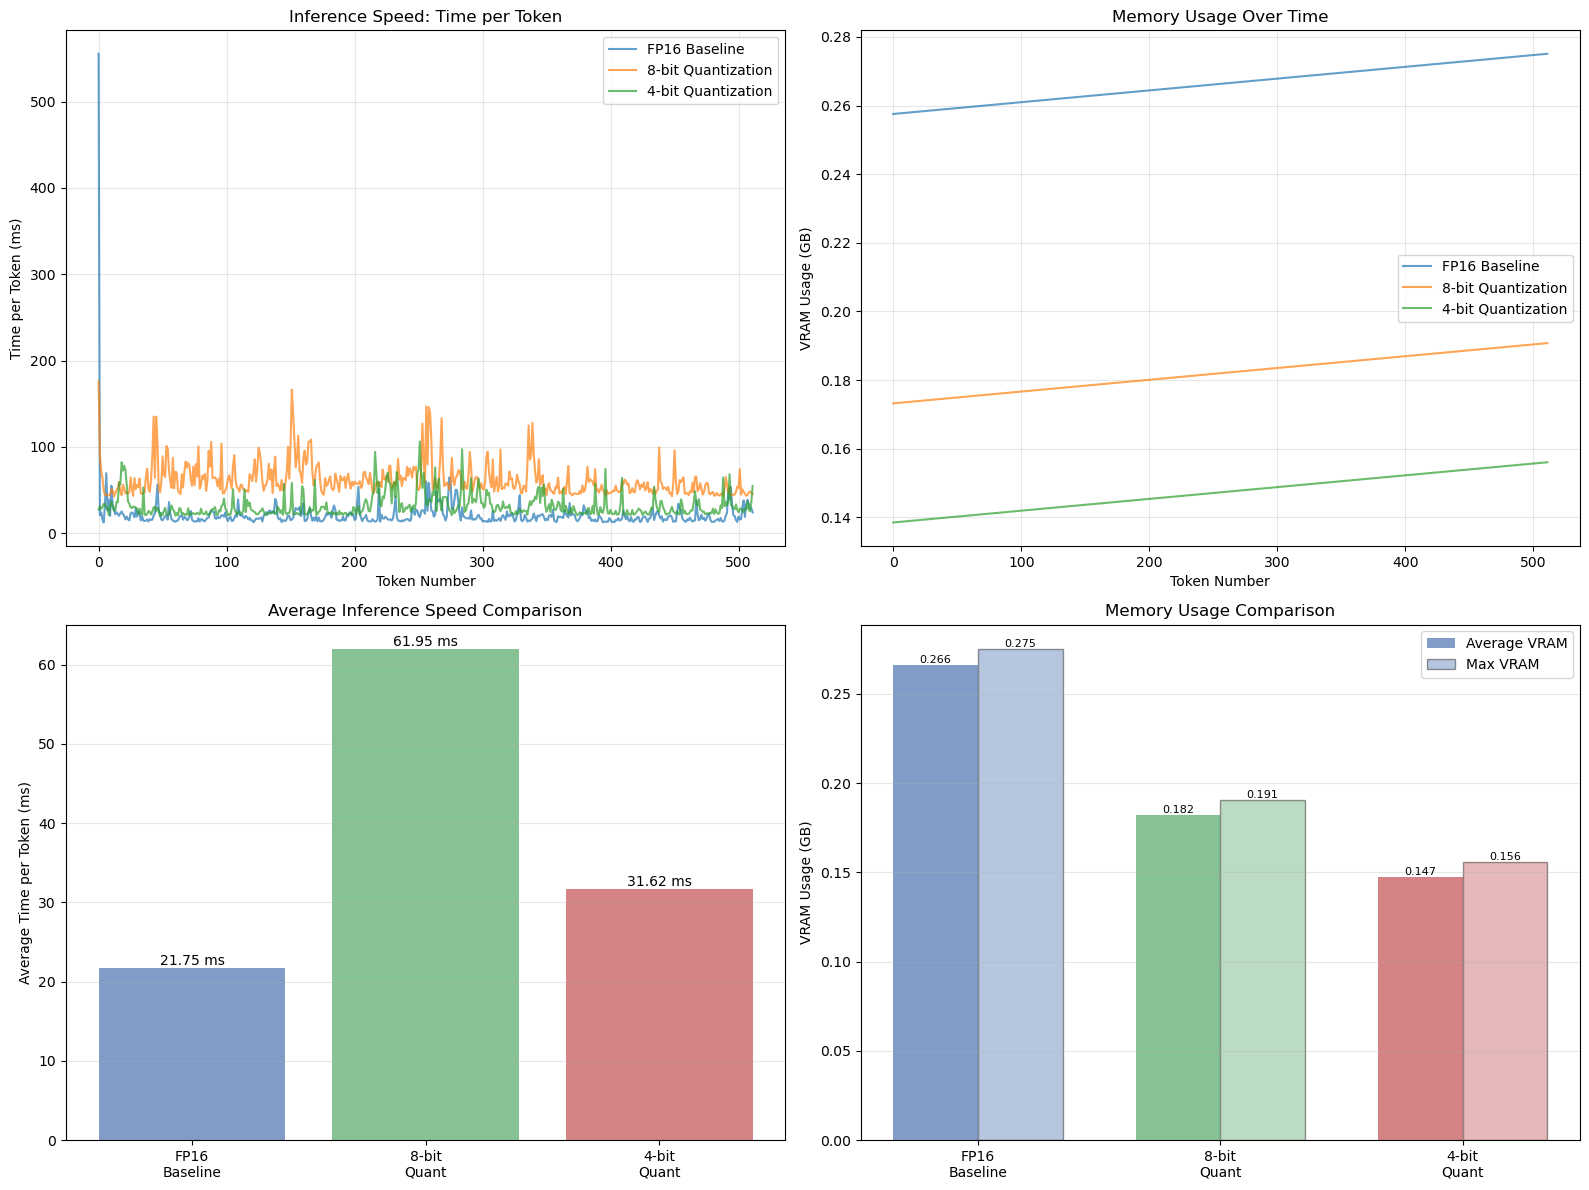


✅ REAL Quantization Experiment Complete!


In [6]:
# --- Visualization ---
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Time per Token Over Generation
ax1.plot(fp16_timings, label='FP16 Baseline', alpha=0.7)
ax1.plot(int8_timings, label='8-bit Quantization', alpha=0.7)
ax1.plot(int4_timings, label='4-bit Quantization', alpha=0.7)
ax1.set_xlabel('Token Number')
ax1.set_ylabel('Time per Token (ms)')
ax1.set_title('Inference Speed: Time per Token')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: VRAM Usage Over Generation
ax2.plot(fp16_vram, label='FP16 Baseline', alpha=0.7)
ax2.plot(int8_vram, label='8-bit Quantization', alpha=0.7)
ax2.plot(int4_vram, label='4-bit Quantization', alpha=0.7)
ax2.set_xlabel('Token Number')
ax2.set_ylabel('VRAM Usage (GB)')
ax2.set_title('Memory Usage Over Time')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Average Performance Comparison
strategies = ['FP16\nBaseline', '8-bit\nQuant', '4-bit\nQuant']
avg_times = [fp16_avg_time, int8_avg_time, int4_avg_time]
colors = ['#4c72b0', '#55a868', '#c44e52']

bars = ax3.bar(strategies, avg_times, color=colors, alpha=0.7)
ax3.set_ylabel('Average Time per Token (ms)')
ax3.set_title('Average Inference Speed Comparison')
ax3.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, val in zip(bars, avg_times):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.2f} ms', ha='center', va='bottom')

# Plot 4: Memory Usage Comparison (Stacked Bar)
avg_vrams = [fp16_avg_vram, int8_avg_vram, int4_avg_vram]
max_vrams = [fp16_max_vram, int8_max_vram, int4_max_vram]

x = range(len(strategies))
width = 0.35

bars1 = ax4.bar([i - width/2 for i in x], avg_vrams, width, 
                label='Average VRAM', color=colors, alpha=0.7)
bars2 = ax4.bar([i + width/2 for i in x], max_vrams, width,
                label='Max VRAM', color=colors, alpha=0.4, edgecolor='black')

ax4.set_ylabel('VRAM Usage (GB)')
ax4.set_title('Memory Usage Comparison')
ax4.set_xticks(x)
ax4.set_xticklabels(strategies)
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig("quantization_comparison.png", dpi=150, bbox_inches='tight')
print("\n📊 Graph saved as 'quantization_comparison.png'")
plt.show()

print("\n" + "="*60)
print("✅ REAL Quantization Experiment Complete!")
print("="*60)